# Face Mask Detection Model Using PyTorch

### Import Libraries

In [1]:
# Nedded Libraries

# PyTorch
import torch 
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A

# OpenCV
import cv2 as cv

# Image Plots
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Data managements
import numpy as np
import pandas as pd

# File interpretation
import os
import xml.etree.ElementTree as ET
import random

# Others
import time

### Find Annotation Files

In [2]:
# Annotations directory path
ann_directory = '.\\annotations'

# List directory
ann_files = os.listdir(ann_directory)

### Find Image Files

In [3]:
# Image directory path
img_directory = '.\\images'

# List directory
img_files = os.listdir(img_directory)

### Interpreting Annotations

First, some auxiliary functions are defined:

In [4]:
def draw_bounding_boxes(img_tensor, bboxes):
    """Draws bounding boxes in given images.

        Args:
          img:
            Image in tensor format.
          bboxes:
            list of lists with bounding boxes coordinates (xmin, ymin, xmax, ymax)

        Returns:
          None
        """
    
    img = torchvision.transforms.ToPILImage()(img_tensor)
    bboxes = bboxes.numpy()
    
    # fetching the dimensions
    wid, hgt = img.size
    print(str(wid) + "x" + str(hgt))

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(img)

    for coordinates in bboxes:
        x = coordinates[0]
        y = coordinates[1]
        width = coordinates[2] - coordinates[0]
        height = coordinates[3] - coordinates[1]

        # Create Rectangle patches and add the patches to the axes
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none', fill=False)
        ax.add_patch(rect)

        # Show cropped bb
        # image_croped = img.crop((x, y, x+width, y+height))
        # fig = plt.figure()
        # plt.imshow(image_croped)

    plt.show(img)
    

In [5]:
def encoded_labels(lst_labels):
    """Encodes label classes from string to integers.

        Labels are encoded accordingly:
            - with_mask => 1
            - mask_weared_incorrect => 2
            - without_mask => 3

            Args:
              lst_labels:
                A list with classes in string format (e.g. ['with_mask', 'mask_weared_incorrect'...]).

            Returns:
              encoded:
                A list with integers that represent each class.
            """

    encoded=[]
    for label in lst_labels:
        if label == "with_mask":
            code = 1
        elif label == "mask_weared_incorrect":
            code = 2
        elif label == "without_mask":
            code = 3
        else:
            code = 0
        encoded.append(code)
    return encoded

In [6]:
def train_model(model, loader, optimizer, scheduler, epochs, device):
    # Train the model
    loss_list = []

    for epoch in range(epochs):
        print('Starting epoch...... {}/{} '.format(epoch + 1, epochs))
        iteration = 0
        loss_sub_list = []
        start = time.time()
        for images, targets in loader:
            # Agregate images in batch loader
            images = list(image.to(device) for image in images)

            # Agregate targets in batch loader
            targets = [{key: val.to(device) for key, val in target.items()} for target in targets]

            # Sets model to train mode (just a flag)
            model.train()

            # Output of model returns loss and detections
            output = model(images, targets)

            # Calculate Cost
            losses = sum(loss for loss in output.values())
            loss_value = losses.item()
            loss_sub_list.append(loss_value)
            print('')

            # Update optimizer and learning rate
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            scheduler.step()
            
            iteration += 1
            print('Iteration: {:d} --> Loss: {:.3f}'.format(iteration, loss_value))
        end = time.time()

        # print the loss of epoch
        epoch_loss = np.mean(loss_sub_list)
        loss_list.append(epoch_loss)
        print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end - start))
        
    return model

In [33]:
def apply_nms(orig_prediction, iou_thresh):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
  
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Create Dataset Class

In [9]:

# Create dataset object
class Dataset(Dataset):

    # Constructor
    def __init__(self, ann_dir, img_dir, transform=None, mode=None):

        # Image directories
        self.ann_dir = ann_dir
        self.img_dir = img_dir

        # The transform is goint to be used on image
        self.transform = transform

        # Create dataframe to hold info
        self.data = pd.DataFrame(columns=['Filename', 'BoundingBoxes', 'Labels'])

        # Append rows with image filename and respective bounding boxes to the df
        for file in enumerate(os.listdir(img_dir)):

            # Find image annotation file
            ann_file_path = os.path.join(ann_dir, file[1][:-4]) + '.xml'

            # Read XML file and return bounding boxes and class attributes
            objects = self.read_XML_classf(ann_file_path)

            # Create list of labels in an image
            list_labels = encoded_labels(objects[0]['labels'])

            # Create list of bounding boxes in an image
            list_bb = []
            for i in objects[0]['objects']:
                list = [i['xmin'], i['ymin'], i['xmax'], i['ymax']]
                list_bb.append(list)

            # Create dataframe object with row containing [(Image file name),(Bounding Box List)]
            df = pd.DataFrame([[file[1], list_bb, list_labels]], columns=['Filename', 'BoundingBoxes', 'Labels'])
            self.data = self.data.append(df)

        if mode == 'train':
            self.data = self.data[:20]
        elif mode == 'validation':
            self.data = self.data[21:26]

        # Number of images in dataset
        self.len = self.data.shape[0]

        # Get the length

    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        # Image file path
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])

        # Open image file and tranform to tensor
        img = Image.open(img_name).convert('RGB')
        img = torchvision.transforms.ToTensor()(img)

        # Get labels
        labels = torch.tensor(self.data.iloc[idx, 2])

        # Get bounding box coordinates
        bbox = torch.tensor(self.data.iloc[idx, 1])

        # If any, aplly tranformations to image and bounding box mask
        if self.transform:
            transformed = self.transform(image=img, bboxes=bbox)
            img = transformed['image']
            bbox = transformed['bboxes']

        # Build Targer dict
        target = {}
        target["boxes"] = bbox
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])

        return img, target

    # XML reader -> returns dictionary with image bounding boxes sizes
    def read_XML_classf(self, ann_file_path):
        bboxes = [{
            'file': ann_file_path,
            'labels': [],
            'objects': []
        }]

        # Reading XML file objects and print Bounding Boxes
        tree = ET.parse(ann_file_path)
        root = tree.getroot()
        objects = root.findall('object')

        for obj in objects:
            # label
            label = obj.find('name').text
            bboxes[0]['labels'].append(label)

            # bbox dimensions
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bboxes[0]['objects'].append({'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

        return bboxes



### Define Image Transformations

In [10]:
transform = A.Compose(
    [ A.HorizontalFlip(p=0.1), 
     A.RandomBrightnessContrast(p=0.4),
     #A.Rotate(limit=40, p=0.5, border_mode = cv.BORDER_CONSTANT)
    ],
    bbox_params= A.BboxParams(format='pascal_voc', min_visibility=0.2, label_fields=[])
)


### Create Data Pipeline

In [11]:
# Create Data Pipeline

# Training Data
dataset_train = Dataset(ann_directory,img_directory, mode = 'train')
loader = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
# Validation Data
dataset_validation = Dataset(ann_directory,img_directory, mode = 'validation')
loader_val = DataLoader(dataset_validation, batch_size=3, shuffle=True, collate_fn=collate_fn)

512x366


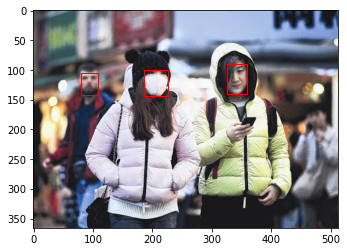

In [12]:
# pick one image from the train set
img, target = dataset_train[0]
img.shape
draw_bounding_boxes(img, target['boxes'])

301x400


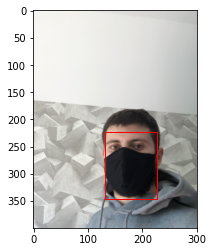

In [13]:
# pick one image from the validation set
img, target = dataset_validation[0]
draw_bounding_boxes(img, target['boxes'])

### Settying up the Faster R-CNN Model

In [14]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Nº of classes: background, no_mask, mask
num_classes = 4 

# Load a pre-trained model on COCO Dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Get number of input features
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

C:\Users\kicop\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
# Set Hyper-parameters

# Network params
params = [p for p in model.parameters() if p.requires_grad]

# Optimizers
# optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)

# Learning Rate
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Number of epochs to perform
epochs=2


### Train the model

In [16]:
model = train_model(model,loader,optimizer,lr_scheduler,epochs,device)

Starting epoch...... 1/2 

Iteration: 1 --> Loss: 2.043

Iteration: 2 --> Loss: 0.968

Iteration: 3 --> Loss: 0.948

Iteration: 4 --> Loss: 0.917

Iteration: 5 --> Loss: 0.732

Iteration: 6 --> Loss: 1.227

Iteration: 7 --> Loss: 0.681
Epoch loss: 1.074 , time used: (1112.5s)
Starting epoch...... 2/2 

Iteration: 1 --> Loss: 0.414

Iteration: 2 --> Loss: 0.901

Iteration: 3 --> Loss: 0.356

Iteration: 4 --> Loss: 1.166

Iteration: 5 --> Loss: 0.325

Iteration: 6 --> Loss: 1.173

Iteration: 7 --> Loss: 0.704
Epoch loss: 0.720 , time used: (1129.2s)


### Prediction

In [46]:
img, target = dataset_validation[2]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    


In [47]:
# Non max supression to reduce the number of bounding boxes
nms_prediction = apply_nms(prediction, iou_thresh=0.3)

tensor([ 0,  1,  2,  3,  6,  9, 11, 15, 16, 17, 18, 19, 22, 24, 37, 38, 52, 55,
        70, 75, 77, 81, 83])


400x289


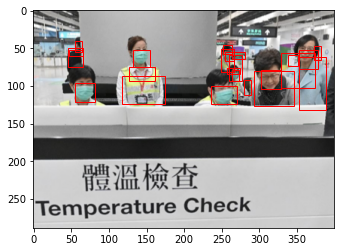

In [49]:
# Draw bounding boxes
draw_bounding_boxes(img, nms_prediction['boxes'])

### Evaluatio Metrics